Dataset Head:
    TweetID     Entity  Sentiment  \
0  Tweet ID     Entity  Sentiment   
1       352     Amazon    Neutral   
2      8312  Microsoft   Negative   
3      4371      CS-GO   Negative   
4      4433     Google    Neutral   

                                       Tweet Content  
0                                      Tweet Content  
1  BBC News - Amazon boss Jeff Bezos rejects clai...  
2  @Microsoft Why do I pay for WORD when it funct...  
3  CSGO matchmaking is so full of closet hacking,...  
4  Now the President is slapping Americans in the...  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TweetID        10 non-null     object
 1   Entity         10 non-null     object
 2   Sentiment      10 non-null     object
 3   Tweet Content  10 non-null     object
dtypes: object(4)
memory usage: 452.0+ bytes

Sentiment Dis

C:\Users\PC\AppData\Local\Temp\ipykernel_22424\3794242593.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=df, order=df['Sentiment'].value_counts().index, palette='viridis')


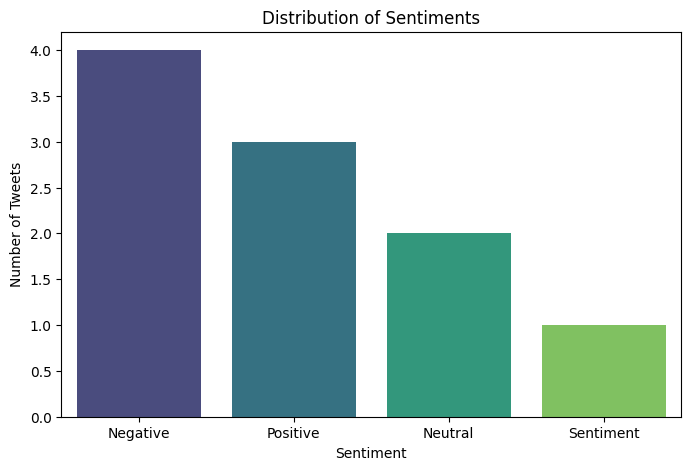

In [2]:
# Import core libraries
import pandas as pd
import numpy as np
import re
import string

# Import NLTK for natural language processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# Import Scikit-learn for machine learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Download necessary NLTK data (only needs to be done once)
# nltk.download('punkt')
# nltk.download('stopwords')

# --- Load the Dataset ---
# We'll use the validation set as our example dataset.
# For a full project, you would combine twitter_training.csv and twitter_validation.csv
try:
    df = pd.read_csv('archive-2/twitter_snippet.csv', header=None)
    df.columns = ['TweetID', 'Entity', 'Sentiment', 'Tweet Content']
except FileNotFoundError:
    print("Make sure 'twitter_snippet.csv' is in the same directory as the notebook.")
    # As a fallback, create a dummy dataframe
    data = {'TweetID': [1, 2, 3, 4],
            'Entity': ['game1', 'game2', 'game3', 'game4'],
            'Sentiment': ['Positive', 'Negative', 'Neutral', 'Positive'],
            'Tweet Content': ["I love this game, it's so much fun!", "This game is terrible, I hate it.", "This is a game.", "An amazing experience, highly recommend!"]}
    df = pd.DataFrame(data)


# --- Initial Data Exploration ---
print("Dataset Head:")
print(df.head())
print("\nDataset Info:")
df.info()

# Drop rows with missing 'Tweet Content'
df.dropna(subset=['Tweet Content'], inplace=True)

print("\nSentiment Distribution:")
print(df['Sentiment'].value_counts())

# Plot the distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Sentiment', data=df, order=df['Sentiment'].value_counts().index, palette='viridis')
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()

In [3]:
# Initialize the stemmer and get English stop words
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_tweet(text):
    """
    Cleans and preprocesses a single tweet.
    - Converts to lowercase
    - Removes URLs, mentions, and hashtags symbol
    - Removes punctuation
    - Tokenizes the text
    - Removes stop words
    - Applies stemming
    """
    if not isinstance(text, str):
        return ""
        
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs, mentions, and the hashtag symbol (but keep the text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+', '', text)
    text = re.sub(r'#', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stop words and apply stemming
    processed_tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    
    # Join tokens back into a single string
    return " ".join(processed_tokens)

# Apply the preprocessing function to the 'Tweet Content' column
print("Preprocessing tweets...")
df['Cleaned Content'] = df['Tweet Content'].apply(preprocess_tweet)

print("\nOriginal vs. Cleaned Content:")
print(df[['Tweet Content', 'Cleaned Content']].head())

Preprocessing tweets...


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - 'C:\\Users\\PC/nltk_data'
    - 'c:\\Users\\PC\\.conda\\envs\\SMC\\nltk_data'
    - 'c:\\Users\\PC\\.conda\\envs\\SMC\\share\\nltk_data'
    - 'c:\\Users\\PC\\.conda\\envs\\SMC\\lib\\nltk_data'
    - 'C:\\Users\\PC\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


In [ ]:
# Initialize the TF-IDF Vectorizer
# max_features limits the number of features to the top 5000, which helps prevent overfitting.
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

# Create the feature matrix (X) and target vector (y)
X = tfidf_vectorizer.fit_transform(df['Cleaned Content'])
y = df['Sentiment']

# The output 'X' is a sparse matrix, which is memory-efficient
print("Shape of TF-IDF matrix:", X.shape)
print("Target vector shape:", y.shape)

In [ ]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

# --- Define models ---
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Linear SVC": LinearSVC()
}

# --- Train and evaluate each model ---
for name, model in models.items():
    print(f"--- Evaluating {name} ---")
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # --- Evaluation ---
    # Accuracy Score
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    # Confusion Matrix
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    print("\n" + "="*30 + "\n")
